# Using Slisemap on the *Auto MPG* dataset

In this notebook we will demonstrate how to call and run Slisemap on the *Auto MPG* dataset. Slisemap can be used directly on the dataset itself, but here we will train a black box regressor using random forest from `sklearn.ensemble.RandomForestRegressor`. We will use Slisemap to interpret the behaviour of this black box model.

In [ ]:
# First we load Slisemap dependencies and other needed packages
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RFRegressor
from sklearn.preprocessing import StandardScaler
# And now the custom Slisemap packages
from data import get_autompg
from slisemap import Slisemap

The *Auto MPG* dataset is a multivariate real-valued dataset with eight attributes describing fuel consumption -related properties of 398 distinct automobiles. We use mpg (miles per gallon) as the target variable and we have additionally removed 6 data items that had missing values. The data consists of 3 discrete and 5 continuous attributes (one of which is mpg) and it is available through UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/auto+mpg

This notebook will, if necessary, download the dataset by calling on "data.py" script located in the experiments folder at the root of the repository.

In [ ]:
# Load the AutoMPG dataset (download it if necessary).
# X contains the covariates, y is the target variable and names are column names.
# X and y has been normalised by `sklearn.preprocessing.StandardScaler`.
# We also remove ten random datapoints from the data for testing later 
X0, y0, names = get_autompg(names=True, normalise=False)
X = StandardScaler().fit_transform(X0)
y = StandardScaler().fit_transform(y0[:, None])
X, X_test, y, y_test, X0, _, y0, _ = train_test_split(X, y, X0, y0, test_size=9, random_state=42)

Instead of simply running Slisemap on the data itself, we showcase how it can be utilised to provide explanations on a black box model. Typically a black box model is produced *via* some machine learning algorithm and the inner workings of the resulting model are too complicated for any human to understand.

In [ ]:
random_forest = RFRegressor(random_state=42).fit(X, y.ravel())
y2 = random_forest.predict(X)

When a user creates a new Slisemap object, they have various options available. The only required variables are the covariates X and the target values y, but there are a number of optional arguments, some of which are detailed below:

    X[i,j]:    The data covariates in an array format (here i=392,j=9).
    y[i]:      The target variable in an array format (here i=392).
    radius:    The radius of the embedding Z. Defaults to 3.5.
    d:         The number of embedding dimensions. Defaults to 2.
    lasso:     Lasso regularisation coefficient (penalty term related to absolute values). Defaults to 0.0.
    ridge:     Ridge regularisation coefficient (penalty term related to squared values). Defaults to 0.0.
    intercept: Should an intercept term be added to local models. Defaults to True.
    cuda:      Use cuda if available. Defaults to True if the data is not too small.
    
In addition to these parameters, it is also possible to change the local model regression function that defaults to linear regression – this functionality goes beyond the scope of this notebook, but is mentioned here as it is an important feature. Next we will create a Slisemap object, optimise the embedding and visualise the results.

In [ ]:
# Fixing the seeds to keep the result static and initiating the Slisemap object with regressor values
torch.manual_seed(42)
np.random.seed(42)
sm = Slisemap(X, y2, lasso=0.01, radius=3.5)
# Optimise the solution using both LBFGS and the escape heuristic as explained in the paper
%time print(f"Loss: {sm.optimise()}")

Loss: 9.93980598449707
CPU times: user 50 µs, sys: 2 µs, total: 52 µs
Wall time: 55.3 µs


Slisemap comes with some built-in visualisation plots. Some optional argumens are detailed below:

    title:     Title of the plot. Optional and defaults to "".
    clusters:  Optional integer and if given, cluster the local models into this number of clusters.
    bars:      Optional True/False or integer. If True, plot the coefficients as a bar plot and
               if an integer, plot that many of the most prominent variables.
    jitter:    Add random (Gaussian) noise to the scatterplot, to show points that are on top of each other.
               Defaults to 0.0.
    variables: Optional list of variable names.

The default plot looks like this:

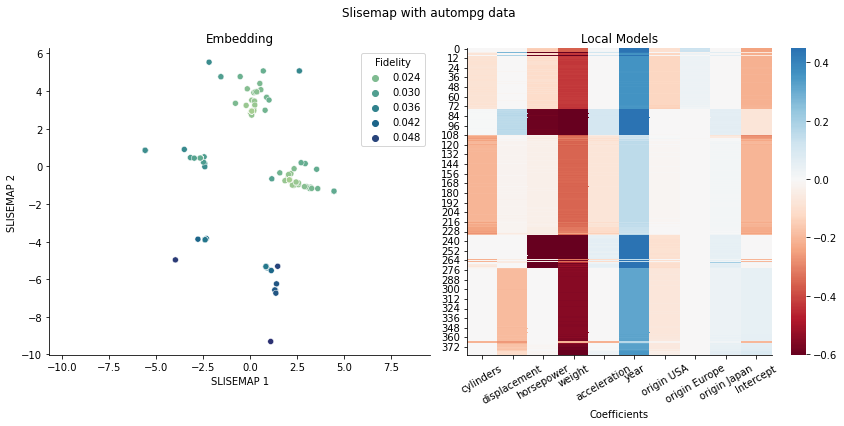

In [ ]:
sm.plot(title="Slisemap with autompg data", variables=names)

On the left is the two-dimensional embedding, with colour based on the fidelity of the local model (i.e. how well it predicts the corresponding data item). On the right is a matrix representation of the coefficients of the local models, sorted such that the points left-to-right in the embedding correspond to the top-to-bottom local models. The displayed coefficients are the dataset attributes as well as intercept term that is initialised to 1 for all data items and optimised similarly to other terms.

To make the investigation of the local models easier we cluster the coefficients using `sklearn.cluster.KMeans`, add some jitter to the embedding and color-code the embedding based on the clustering:

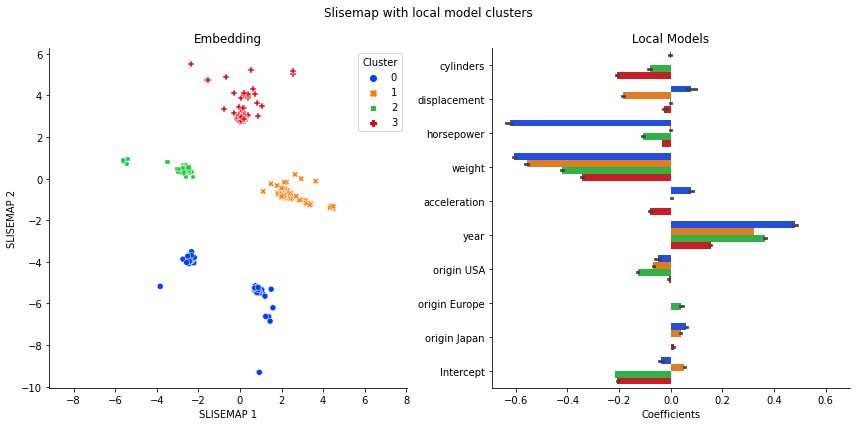

In [ ]:
clusters = 4
sm.plot(title="Slisemap with local model clusters", clusters=clusters, bars=True, jitter=0.1, variables=names)

Now we see that some points in the original embedding actually consisted of multiple points. This happens when the local models are identical. The bar plots on the right panel correspond with the coefficients of the cluster mean (i.e. the local linear model of the cluster mean). We also see that some variables are almost useless for all local models, so lets ignore them for now:

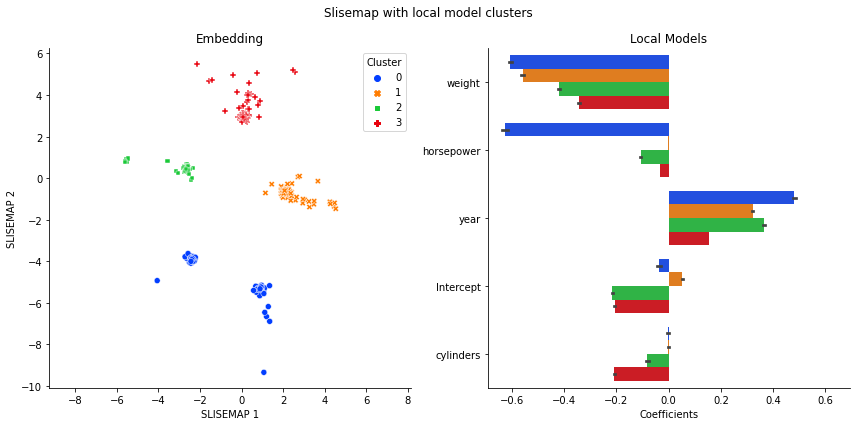

In [ ]:
bars = 5
sm.plot(title="Slisemap with local model clusters", clusters=clusters, bars=bars, jitter=0.1, variables=names)

We can now identify which attributes play the most significant role within each cluster, i.e. which attributes in a given cluster are the most important in getting the predictions correct. The most important attributes (when the attribute increases) contributing negatively to fuel efficiency are weight, horsepower and if the car originated from the USA. We also get one important positivily contributing attribute, which is the year the car was made. Let us now take a bit closer look at the differences between clusters 0 and 3.

Next we will take a more direct look at the distribution of attributes between the clusters. We use Slisemap inbuilt plotting script that utilises `seaborn.kdeplot` to place a Gaussian kernel at each datapoint to visualise the value distributions.

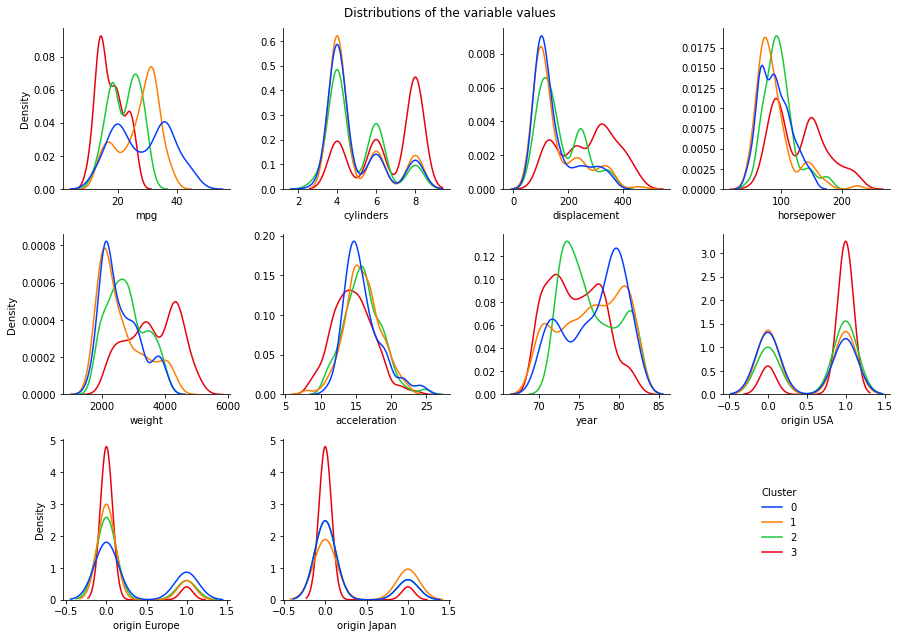

In [ ]:
sm.plot_dist(X=X0, Y=y0, title="Distributions of the variable values", clusters=clusters, variables=names, targets="mpg", height=3)

We can now characterise the differences between cluster 0 and cluster 3 more clearly, focusing on the attributes we identified before. On average, cluster 0 contains lighter and newer cars with less horsepower and considerably smaller amount of which originated from the USA than cluster 3. Noticeably, horsepower is not a factor explaining the predictions for cluster 3, where weight and origin are the most dominant negative attributes. Also, the positive effect on fuel consumption of the "year" attribute, indicates that fuel economy has increased as time goes by – with a noticeable difference of effect between the clusters.

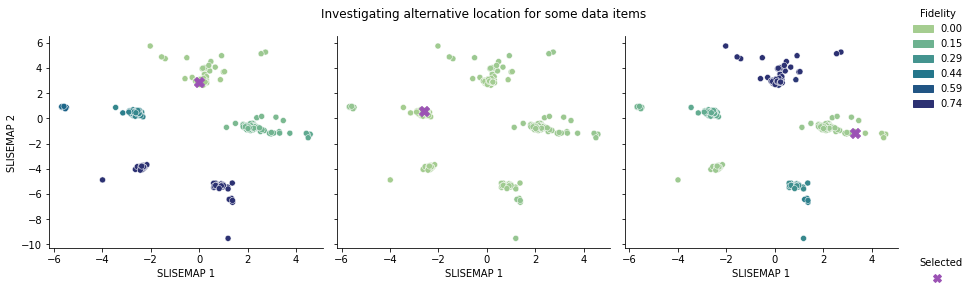

In [ ]:
sm.plot_position(index=[1,100,300], title="Investigating alternative location for some data items", height=4, jitter=0.1)

Here we have three instances, where we have taken a point in the embedding (marked) and then calculate what would be the fidelity of that point if it would be projected on top of one of the other points in the embedding. In the leftmost panel, the point could lie nearly everywhere in the embedding, but for the other two (center and right) panels) there're clearly areas where the point cannot be projected. This shows o highlight that the solutions of Slisemap is not unique and some overlap between the local models is expected, especially neighbouring (in the embed-
ding) local models should be similar.

It is also possible to investigate how new data items would be projected onto the embedding and what their local white box models would be. The user may also choose whether to fine tune the embedding and allow new points to affect each other. This can be useful for, e.g., speeding up large datasets via subsampling or detecting concept drift.

Here we demonstrate how a user can calculate the regressor values of unseen datapoints, using the same black box model, and how a user could generate the embedding and local models for the new data items.

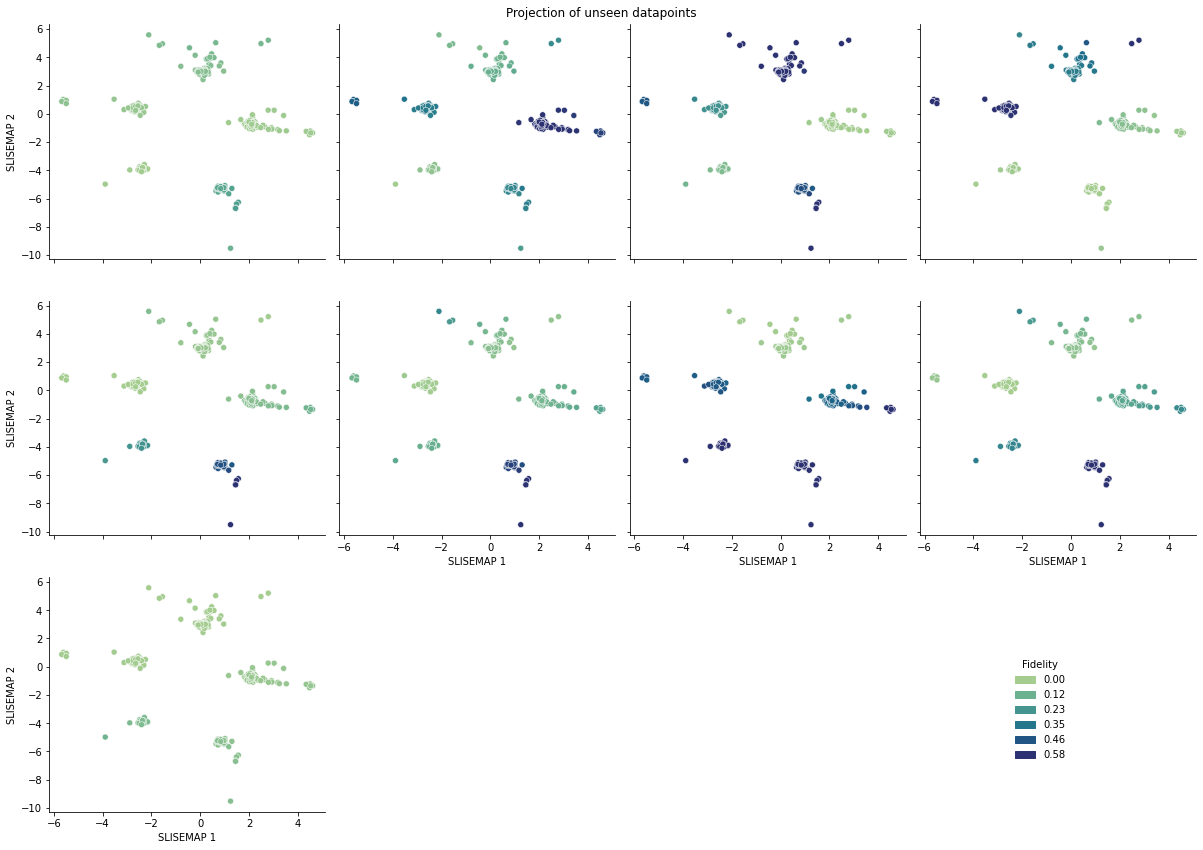

In [ ]:
# These are examples on how to generate the embeddings and local models for new datapoints
y3 = random_forest.predict(X_test)
Z_test, B_test = sm.fit_new(X_test, y3)
# Here we plot similar plots as above: fidelities of a new points when projected on the existing embedding
sm.plot_position(X_test, y3, title="Projection of unseen datapoints", height=4, jitter=0.1)